# *Modeling Part: Random Forest*

****************************************************************************************************************************************

In [8]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [9]:
url_final = 'https://dl.dropboxusercontent.com/scl/fi/ep8vuirz46gkhw4a3yfw6/final_dataset.csv?rlkey=b9ji5utoaahhkmsoebup6q95q&dl=1'
df_final = pd.read_csv(url_final)

In [10]:
df_final.shape

(284700, 25)

In [11]:
df_final.head()

,COIL,MT_ADJUSTED,DATE,TIME_START_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,SPEED_PROCESS,FILL_TIRO,LASER_FRN_1,ELET_FE2,...,LASER_FRN_9,DEC_FE2,DEC_FE3,LASER_FRN_8,SPZ1_R1_ASS,FRN_FURNACE_PRESSURE,AIR_CH4_1,FILL_FORZA,PRES_ZONA3_MEASURED,Has_Defect
0,297712,0.0,2019-03-03,16:00:17.140,-0.626250,0.589075,-1.749652,-0.003943,1.130454,-0.024409,...,-0.921559,-0.019089,0.006705,-3.281993,-0.005561,3.480863,5.618876,-0.006274,-0.362265,0.0
1,297712,7.0,2019-03-03,16:01:02.140,-0.548642,0.310833,-1.423870,-0.003943,1.167358,-0.024409,...,-0.882066,-0.019089,0.006705,-3.286931,-0.005561,4.155847,5.606975,-0.006274,-3.121354,0.0
2,297712,14.0,2019-03-03,16:01:32.140,-0.489710,0.219359,-1.249998,-0.003943,1.169191,-0.024409,...,-0.895256,-0.019089,0.006705,-3.283506,-0.005561,3.724010,5.505825,-0.006274,-2.903597,0.0
3,297712,21.0,2019-03-03,16:01:47.080,-0.472777,0.560960,-1.250524,-2.503042,1.183099,-0.024409,...,-0.888345,-0.019089,0.006705,-3.239610,-0.005561,3.202527,5.599273,-1.168397,-2.357400,0.0
4,297712,28.0,2019-03-03,16:02:17.080,-0.457463,0.437551,-1.250053,-2.717672,1.189643,-2.331214,...,-0.887054,-2.294722,1.560311,-3.249343,-0.574788,2.952983,5.556279,-1.176393,-1.833425,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [12]:
# Get unique coil IDs and split them
unique_coils = df_final['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_final[df_final['COIL'].isin(train_coils)]
val_df = df_final[df_final['COIL'].isin(val_coils)]
test_df = df_final[df_final['COIL'].isin(test_coils)]


In [13]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)   
y_test = test_df[target]     

### Random Forest 

Optimized Hyperparameter Tuning for Random Forest Classifier with Reduced Computational Complexity

In [14]:
# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100],  # Keeping one option to reduce combinations
    'max_depth': [10, None],  # A reasonable depth, and None for fully grown trees
    'min_samples_split': [2],  # Default value
    'min_samples_leaf': [1],  # Default value
    'bootstrap': [True]  # Keeping bootstrapping enabled
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Assuming X_train and y_train are your training features and labels
grid_search.fit(X_train, y_train)

# Get the best parameters and use them to create the best model
best_params = grid_search.best_params_
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model
best_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Validation Accuracy: 0.8001415110620232
Testing Accuracy: 0.7879570712762453

**Classification report for Random Forest Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85     39859
         1.0       0.66      0.64      0.65     17818

    accuracy                           0.79     57677
   macro avg       0.75      0.75      0.75     57677
weighted avg       0.79      0.79      0.79     57677



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier on the test set')

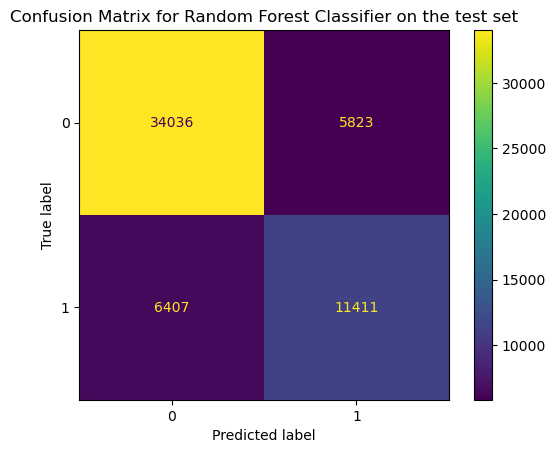

In [ ]:
# Predict on the validation set
y_val_pred = best_rf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Predict on the test set
y_test_pred = best_rf.predict(X_test)
# Calculate the accuracy of the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}\n")

# Print out the classification report which provides a summary of the model's performance
print("**Classification report for Random Forest Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred))

# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on the test set')
